In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ef-msu-2024-comp-1/train.csv
/kaggle/input/ef-msu-2024-comp-1/test.csv


# Preprocessing

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_log_error
from scipy.stats import randint, uniform

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'id'], dtype='object')


<Axes: >

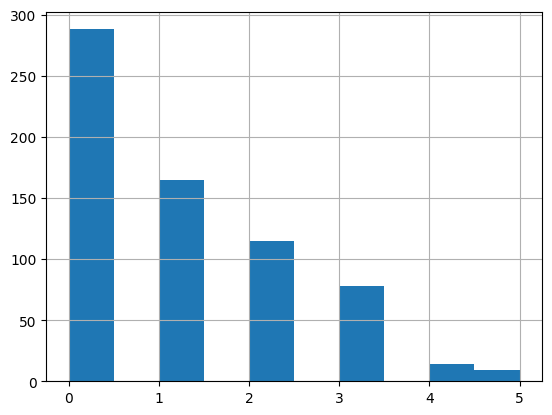

In [3]:
train = pd.read_csv('/kaggle/input/ef-msu-2024-comp-1/train.csv')
test = pd.read_csv('/kaggle/input/ef-msu-2024-comp-1/test.csv')
print(train.columns)
train.children.hist()

In [4]:
X = train.drop(['id', 'charges'], axis=1)
y = np.log(train['charges'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['children'])

In [7]:
cat_columns = X_train.select_dtypes(include=["object"]).columns
num_columns = X_train.select_dtypes(include=["int64", "float64"]).columns

preprocessing = ColumnTransformer([
    ("cat_preprocessing", OneHotEncoder(), cat_columns),
    ("num_preprocessing", StandardScaler(), num_columns)
])

In [8]:
preprocessed_X_train = pd.DataFrame(preprocessing.fit_transform(X_train),
                                    columns=preprocessing.get_feature_names_out())

preprocessed_X_train.num_preprocessing__bmi.hist()

# Model creating

# Random Forest model

In [9]:
rf_model = make_pipeline(
    preprocessing,
    RandomForestRegressor(random_state=42)
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))

# Gradient Boosting Model

In [10]:
gb_model = make_pipeline(
    preprocessing,
    GradientBoostingRegressor(random_state=42)
)

gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))

# Model tuning

In [12]:
def rmsle(y_true, y_pred):
    y_true = np.exp(y_true)
    y_pred = np.exp(y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
 
gb = gb_model

param_dist = {
     'gradientboostingregressor__learning_rate': uniform(0,1),
     'gradientboostingregressor__n_estimators': randint(10, 1000),
     'gradientboostingregressor__min_samples_split': randint(2, 20),
     'gradientboostingregressor__min_samples_leaf': randint(2, 20),
     'gradientboostingregressor__max_depth': randint(2, 20),
     'gradientboostingregressor__max_features': uniform(0,1),
     'gradientboostingregressor__max_leaf_nodes': randint(2, 20)
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

random_search = RandomizedSearchCV(
     estimator=gb,
     param_distributions=param_dist,
     n_iter=10,
     scoring=rmsle_scorer,
     cv=kf,
     random_state=42,
     verbose=1
)

random_search.fit(X_train, y_train) 


print(f"Best parameters: {random_search.best_params_}")

print(f"Best RMSLE: {abs(random_search.best_score_)}")

In [11]:
gb_model = make_pipeline(
    preprocessing,
    GradientBoostingRegressor(random_state=42,
                             learning_rate=0.01,
                             n_estimators=520,
                             min_samples_split=20,
                             min_samples_leaf=12,
                             max_depth=3,
                             max_features=0.75,
                             max_leaf_nodes=15)
)

gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
rmsle

0.05031183689821991

# Cross_validation

#### random forest

In [13]:
best_model = random_search.best_estimator_
rmsle_scores = []

for train_index, test_index in kf.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    best_model.fit(X_train_cv, y_train_cv)

    y_pred_cv = best_model.predict(X_test_cv)


    score = rmsle(y_test_cv, y_pred_cv)
    rmsle_scores.append(score)

mean_rmsle = np.mean(rmsle_scores)
print(f"Mean RMSLE: {mean_rmsle}")
print(f'All RMSLE scores: {rmsle_scores}')

#### gb randomized search

In [14]:
best_model = random_search.best_estimator_
rmsle_scores = []

for train_index, test_index in kf.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    best_model.fit(X_train_cv, y_train_cv)

    y_pred_cv = best_model.predict(X_test_cv)


    score = rmsle(y_test_cv, y_pred_cv)
    rmsle_scores.append(score)

mean_rmsle = np.mean(rmsle_scores)
print(f"Mean RMSLE: {mean_rmsle}")

#### gb self-made

In [15]:
def rmsle(y_true, y_pred):
    y_true = np.exp(y_true)
    y_pred = np.exp(y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scores = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    gb_model.fit(X_train_cv, y_train_cv)

    y_pred_cv = gb_model.predict(X_test_cv)


    score = rmsle(y_test_cv, y_pred_cv)
    rmsle_scores.append(score)

mean_rmsle = np.mean(rmsle_scores)
print(f"Mean RMSLE: {mean_rmsle}")

Средний RMSLE: 0.35963993509831965


In [16]:
rmsle_scores

[0.310072690438169,
 0.2243792782700289,
 0.3465850914316436,
 0.41893043764053195,
 0.4590556256323482,
 0.3055610683705513,
 0.2996262287593252,
 0.23108607522412639,
 0.42854554096742836,
 0.5725573142490433]

## Final learning and prediction

In [17]:
test_purified = test.drop('id', axis=1)

gb_model.fit(X, y)
test_pred = gb_model.predict(test_purified)
test_pred_no_log = np.exp(test_pred)

In [18]:
submission = pd.DataFrame()
submission["id"] = test.id
submission["charges"] = test_pred_no_log
submission.head()

,id,charges
0,770,9168.464972
1,771,5483.866833
2,772,26074.005584
3,773,8772.898673
4,774,28691.560503


In [19]:
submission.to_csv("submission_baseline.csv", index=False)